In [3]:
# import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import math
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [4]:
!nvidia-smi

Wed Jan 14 04:17:17 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   38C    P8              2W /   55W |     511MiB /   8188MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
path = "/home/vector/iitd/dataset/master_dataset/"

In [ ]:
output_class = 10
# batch_size = 160
batch_size = 128
img_rows = img_cols = 400
epoch = 200
channels = 3
# momentumm = 0.9252
# chanDim = -1

In [8]:
CLASSES = sorted(os.listdir(path))
class_to_id = {c: i for i, c in enumerate(CLASSES)}

image_paths = []
labels = []

for cls in CLASSES:
    cls_path = os.path.join(path, cls)
    for f in os.listdir(cls_path):
        image_paths.append(os.path.join(cls_path, f))
        labels.append(class_to_id[cls])

In [9]:
len(image_paths), len(labels)

(59689, 59689)

In [10]:
X_train, X_tmp, y_train, y_tmp = train_test_split(
    image_paths, labels, test_size=0.25, stratify=labels, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.25, stratify=y_tmp, random_state=42
)


In [11]:
print(len(X_test), len(y_test))
print(len(X_train), len(y_train))

3731 3731
44766 44766


In [12]:
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(
        img,
        channels=channels,
        expand_animations=False
    )
    img = tf.image.resize(
        img,
        (img_rows, img_cols),
        method=tf.image.ResizeMethod.BILINEAR
    )
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)    # specific to InceptionResNetV2
    
    img.set_shape((img_rows, img_cols, channels))

    return img, tf.one_hot(label, output_class)

In [13]:
def make_ds(X, y, batch_size = 128,training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1024)
    return ds.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(X_train, y_train,128, True)
val_ds   = make_ds(X_val, y_val)
test_ds  = make_ds(X_test, y_test)


train_ds = train_ds.repeat()
val_ds   = val_ds.repeat()
test_ds  = test_ds.repeat()

I0000 00:00:1768344451.411200  119191 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5604 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.98285973..0.9863566].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.98698366..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9987956..1.0].
Clipping input data to the valid range for 

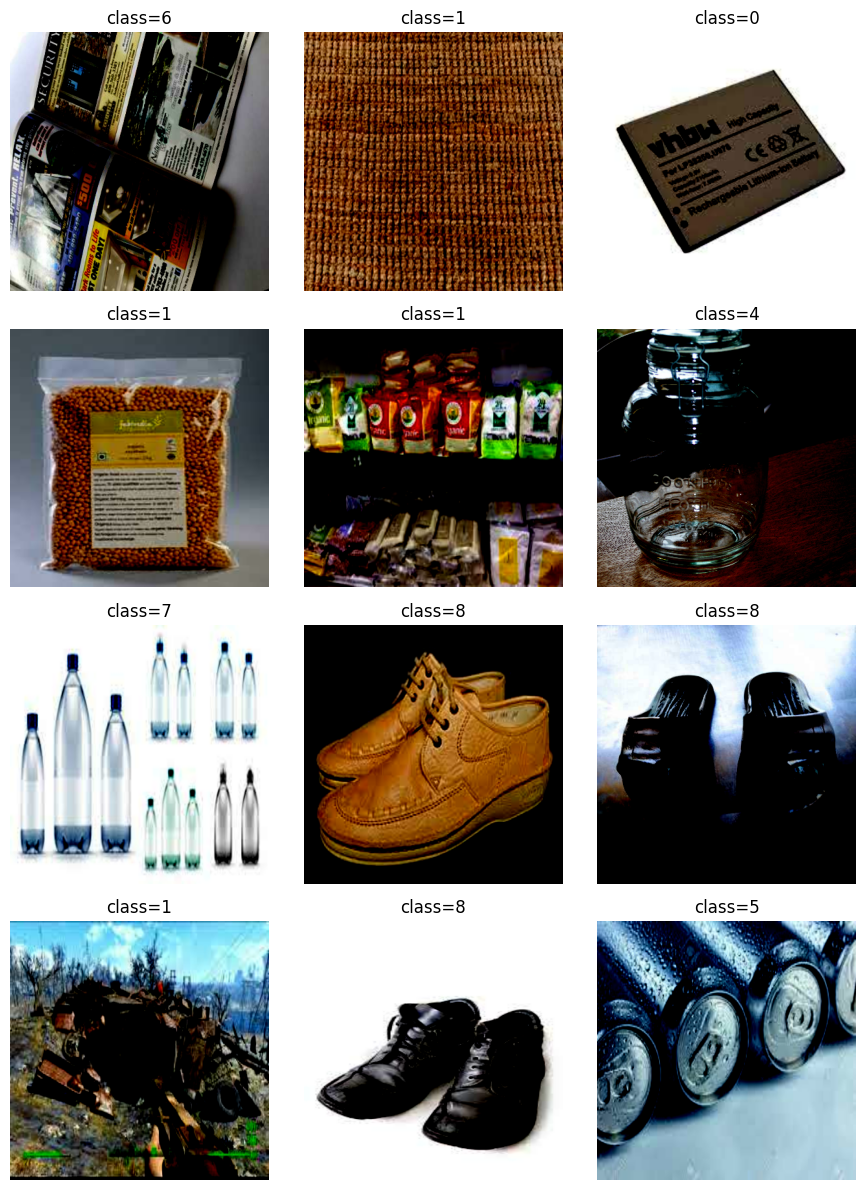

In [15]:
def plot_n_images(dataset, n):
    images, labels = next(iter(dataset))
    n = min(n, images.shape[0])

    cols = int(math.sqrt(n))
    rows = math.ceil(n / cols)

    plt.figure(figsize=(cols * 3, rows * 3))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        cls = tf.argmax(labels[i]).numpy()
        plt.title(f"class={cls}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_n_images(train_ds, n=12)

## Model preperation

In [ ]:


def build_convowaste_model(input_shape=(400, 400, 3),num_classes=10,lr=1e-4):
    base_model = InceptionResNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )

    # Freeze base model
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Custom dense layers (as described)
    x = Dense(1080, activation="relu")(x)
    x = Dropout(0.5)(x)

    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        # metrics=["accuracy"]
        metrics=["accuracy", tf.keras.metrics.CategoricalAccuracy(name="cat_acc")]

    )

    return model


In [ ]:
model = build_convowaste_model(
    input_shape=(img_rows, img_cols, channels),
    num_classes=output_class,
    lr=1e-4
)

# model.summary()

In [ ]:
callbacks = [
    ModelCheckpoint(
        filepath="best_model.keras",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=7,
        min_lr=1e-7,
        verbose=1
    )
]


In [28]:
def plot_all_history(history):
    h = history.history
    epochs = range(1, len(next(iter(h.values()))) + 1)

    # Identify metrics
    train_metrics = [k for k in h.keys() if not k.startswith("val_") and k != "learning_rate"]
    has_lr = "learning_rate" in h

    total_plots = len(train_metrics) + (1 if has_lr else 0)
    cols = 2 if total_plots > 1 else 1
    rows = math.ceil(total_plots / cols)

    plt.figure(figsize=(7 * cols, 4.5 * rows))

    idx = 1

    # Plot metrics
    for k in train_metrics:
        plt.subplot(rows, cols, idx)
        plt.plot(epochs, h[k], label=f"train_{k}")
        if f"val_{k}" in h:
            plt.plot(epochs, h[f"val_{k}"], label=f"val_{k}")
        plt.xlabel("Epoch")
        plt.ylabel(k)
        plt.legend()
        plt.grid(True)
        idx += 1

    # Plot learning rate
    if has_lr:
        plt.subplot(rows, cols, idx)
        plt.plot(epochs, h["learning_rate"], label="learning_rate")
        plt.xlabel("Epoch")
        plt.ylabel("LR")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


## Phase 1

In [20]:
# ensuring model fits on GPU
history = model.fit(
    train_ds,
    steps_per_epoch  = len(X_train) // batch_size,
    validation_steps = len(X_val) // batch_size,
    validation_data=val_ds,
    epochs=1,
    callbacks=callbacks
)
print(history.history.keys())

2026-01-14 04:18:22.931599: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fe508001950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-14 04:18:22.931618: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2026-01-14 04:18:23.439970: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-14 04:18:26.627138: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2026-01-14 04:18:28.031423: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21671', 4 bytes spill stores, 4 bytes spill loads

2026-01-14 04:18:28.404703: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:3

349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5727 - cat_acc: 0.5727 - loss: 1.3283

2026-01-14 04:26:34.512101: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5501', 13008 bytes spill stores, 13288 bytes spill loads




Epoch 1: val_loss improved from None to 0.24978, saving model to best_model.keras

Epoch 1: finished saving model to best_model.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 607s 2s/step - accuracy: 0.7448 - cat_acc: 0.7448 - loss: 0.8349 - val_accuracy: 0.9254 - val_cat_acc: 0.9254 - val_loss: 0.2498 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.
dict_keys(['accuracy', 'cat_acc', 'loss', 'val_accuracy', 'val_cat_acc', 'val_loss', 'learning_rate'])


In [21]:
# bottom layer trained on total of 3 epochs 
history = model.fit(
    train_ds,
    steps_per_epoch  = len(X_train) // batch_size,
    validation_steps = len(X_val) // batch_size,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8991 - cat_acc: 0.8991 - loss: 0.3421
Epoch 1: val_loss improved from 0.24978 to 0.19536, saving model to best_model.keras

Epoch 1: finished saving model to best_model.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 523s 1s/step - accuracy: 0.9075 - cat_acc: 0.9075 - loss: 0.3182 - val_accuracy: 0.9419 - val_cat_acc: 0.9419 - val_loss: 0.1954 - learning_rate: 1.0000e-04
Epoch 2/20


2026-01-14 04:37:50.957740: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-14 04:37:51.640116: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_20860', 4 bytes spill stores, 4 bytes spill loads

2026-01-14 04:37:51.688738: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21671', 100 bytes spill stores, 100 bytes spill loads

2026-01-14 04:37:51.846819: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21291', 8 

349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9266 - cat_acc: 0.9266 - loss: 0.2526

2026-01-14 04:45:41.499349: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 268440576 bytes after encountering the first element of size 268440576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 2: val_loss improved from 0.19536 to 0.17109, saving model to best_model.keras

Epoch 2: finished saving model to best_model.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 579s 2s/step - accuracy: 0.9285 - cat_acc: 0.9285 - loss: 0.2442 - val_accuracy: 0.9485 - val_cat_acc: 0.9485 - val_loss: 0.1711 - learning_rate: 1.0000e-04
Epoch 3/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9365 - cat_acc: 0.9365 - loss: 0.2147

2026-01-14 04:54:33.994151: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 268440576 bytes after encountering the first element of size 268440576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 3: val_loss improved from 0.17109 to 0.15656, saving model to best_model.keras

Epoch 3: finished saving model to best_model.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 533s 2s/step - accuracy: 0.9377 - cat_acc: 0.9377 - loss: 0.2089 - val_accuracy: 0.9527 - val_cat_acc: 0.9527 - val_loss: 0.1566 - learning_rate: 1.0000e-04
Epoch 4/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9458 - cat_acc: 0.9458 - loss: 0.1849

2026-01-14 05:03:26.895995: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 268440576 bytes after encountering the first element of size 268440576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 4: val_loss improved from 0.15656 to 0.14079, saving model to best_model.keras

Epoch 4: finished saving model to best_model.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 532s 2s/step - accuracy: 0.9461 - cat_acc: 0.9461 - loss: 0.1815 - val_accuracy: 0.9578 - val_cat_acc: 0.9578 - val_loss: 0.1408 - learning_rate: 1.0000e-04
Epoch 5/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9499 - cat_acc: 0.9499 - loss: 0.1659

2026-01-14 05:12:12.635907: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 268440576 bytes after encountering the first element of size 268440576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 5: val_loss improved from 0.14079 to 0.12661, saving model to best_model.keras

Epoch 5: finished saving model to best_model.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 526s 2s/step - accuracy: 0.9515 - cat_acc: 0.9515 - loss: 0.1626 - val_accuracy: 0.9626 - val_cat_acc: 0.9626 - val_loss: 0.1266 - learning_rate: 1.0000e-04
Epoch 6/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9540 - cat_acc: 0.9540 - loss: 0.1510

2026-01-14 05:21:04.922058: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 268440576 bytes after encountering the first element of size 268440576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 6: val_loss improved from 0.12661 to 0.11774, saving model to best_model.keras

Epoch 6: finished saving model to best_model.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 532s 2s/step - accuracy: 0.9546 - cat_acc: 0.9546 - loss: 0.1474 - val_accuracy: 0.9651 - val_cat_acc: 0.9651 - val_loss: 0.1177 - learning_rate: 1.0000e-04
Epoch 7/20
  5/349 ━━━━━━━━━━━━━━━━━━━━ 6:52 1s/step - accuracy: 0.9597 - cat_acc: 0.9597 - loss: 0.1033

2026-01-14 05:22:55.625756: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 245765120 bytes after encountering the first element of size 245765120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9591 - cat_acc: 0.9591 - loss: 0.1348

2026-01-14 05:29:57.597513: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 268440576 bytes after encountering the first element of size 268440576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 7: val_loss improved from 0.11774 to 0.10944, saving model to best_model.keras

Epoch 7: finished saving model to best_model.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 532s 2s/step - accuracy: 0.9598 - cat_acc: 0.9598 - loss: 0.1313 - val_accuracy: 0.9673 - val_cat_acc: 0.9673 - val_loss: 0.1094 - learning_rate: 1.0000e-04
Epoch 8/20
  6/349 ━━━━━━━━━━━━━━━━━━━━ 6:55 1s/step - accuracy: 0.9733 - cat_acc: 0.9733 - loss: 0.0895

2026-01-14 05:31:49.306076: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 245765120 bytes after encountering the first element of size 245765120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9638 - cat_acc: 0.9638 - loss: 0.1194

2026-01-14 05:38:54.634237: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 268440576 bytes after encountering the first element of size 268440576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 8: val_loss improved from 0.10944 to 0.10489, saving model to best_model.keras

Epoch 8: finished saving model to best_model.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.9641 - cat_acc: 0.9641 - loss: 0.1176 - val_accuracy: 0.9677 - val_cat_acc: 0.9677 - val_loss: 0.1049 - learning_rate: 1.0000e-04
Epoch 9/20
  7/349 ━━━━━━━━━━━━━━━━━━━━ 6:50 1s/step - accuracy: 0.9561 - cat_acc: 0.9561 - loss: 0.1250

2026-01-14 05:40:49.123511: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 245765120 bytes after encountering the first element of size 245765120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9647 - cat_acc: 0.9647 - loss: 0.1122

2026-01-14 05:47:51.120242: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 268440576 bytes after encountering the first element of size 268440576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 9: val_loss improved from 0.10489 to 0.10172, saving model to best_model.keras

Epoch 9: finished saving model to best_model.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 535s 2s/step - accuracy: 0.9669 - cat_acc: 0.9669 - loss: 0.1086 - val_accuracy: 0.9688 - val_cat_acc: 0.9688 - val_loss: 0.1017 - learning_rate: 1.0000e-04
Epoch 10/20
  8/349 ━━━━━━━━━━━━━━━━━━━━ 6:53 1s/step - accuracy: 0.9666 - cat_acc: 0.9666 - loss: 0.1093

2026-01-14 05:49:45.823904: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 245765120 bytes after encountering the first element of size 245765120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9696 - cat_acc: 0.9696 - loss: 0.1014

2026-01-14 05:56:46.329123: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 268440576 bytes after encountering the first element of size 268440576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 10: val_loss improved from 0.10172 to 0.08978, saving model to best_model.keras

Epoch 10: finished saving model to best_model.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 535s 2s/step - accuracy: 0.9711 - cat_acc: 0.9711 - loss: 0.0961 - val_accuracy: 0.9737 - val_cat_acc: 0.9737 - val_loss: 0.0898 - learning_rate: 1.0000e-04
Epoch 11/20
  9/349 ━━━━━━━━━━━━━━━━━━━━ 6:46 1s/step - accuracy: 0.9768 - cat_acc: 0.9768 - loss: 0.0760

2026-01-14 05:58:41.986226: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 245765120 bytes after encountering the first element of size 245765120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9722 - cat_acc: 0.9722 - loss: 0.0928

2026-01-14 06:05:40.719120: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 268440576 bytes after encountering the first element of size 268440576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 11: val_loss improved from 0.08978 to 0.08400, saving model to best_model.keras

Epoch 11: finished saving model to best_model.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 534s 2s/step - accuracy: 0.9726 - cat_acc: 0.9726 - loss: 0.0908 - val_accuracy: 0.9751 - val_cat_acc: 0.9751 - val_loss: 0.0840 - learning_rate: 1.0000e-04
Epoch 12/20
 10/349 ━━━━━━━━━━━━━━━━━━━━ 6:50 1s/step - accuracy: 0.9828 - cat_acc: 0.9828 - loss: 0.0517

2026-01-14 06:07:37.038109: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 245765120 bytes after encountering the first element of size 245765120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9742 - cat_acc: 0.9742 - loss: 0.0817

2026-01-14 06:14:38.182876: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 268440576 bytes after encountering the first element of size 268440576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 12: val_loss improved from 0.08400 to 0.08075, saving model to best_model.keras

Epoch 12: finished saving model to best_model.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 541s 2s/step - accuracy: 0.9743 - cat_acc: 0.9743 - loss: 0.0822 - val_accuracy: 0.9749 - val_cat_acc: 0.9749 - val_loss: 0.0808 - learning_rate: 1.0000e-04
Epoch 13/20
 11/349 ━━━━━━━━━━━━━━━━━━━━ 6:39 1s/step - accuracy: 0.9777 - cat_acc: 0.9777 - loss: 0.0831

2026-01-14 06:16:39.127168: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 245765120 bytes after encountering the first element of size 245765120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9764 - cat_acc: 0.9764 - loss: 0.0758

2026-01-14 06:23:29.373187: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 268440576 bytes after encountering the first element of size 268440576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 13: val_loss improved from 0.08075 to 0.07345, saving model to best_model.keras

Epoch 13: finished saving model to best_model.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 523s 1s/step - accuracy: 0.9771 - cat_acc: 0.9771 - loss: 0.0736 - val_accuracy: 0.9779 - val_cat_acc: 0.9779 - val_loss: 0.0734 - learning_rate: 1.0000e-04
Epoch 14/20
 12/349 ━━━━━━━━━━━━━━━━━━━━ 6:25 1s/step - accuracy: 0.9781 - cat_acc: 0.9781 - loss: 0.0648

2026-01-14 06:25:22.550277: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 245765120 bytes after encountering the first element of size 245765120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9786 - cat_acc: 0.9786 - loss: 0.0681

2026-01-14 06:31:51.954528: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 268440576 bytes after encountering the first element of size 268440576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 14: val_loss improved from 0.07345 to 0.07213, saving model to best_model.keras

Epoch 14: finished saving model to best_model.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 502s 1s/step - accuracy: 0.9788 - cat_acc: 0.9788 - loss: 0.0672 - val_accuracy: 0.9791 - val_cat_acc: 0.9791 - val_loss: 0.0721 - learning_rate: 1.0000e-04
Epoch 15/20
 13/349 ━━━━━━━━━━━━━━━━━━━━ 6:23 1s/step - accuracy: 0.9870 - cat_acc: 0.9870 - loss: 0.0481

2026-01-14 06:33:45.524874: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 245765120 bytes after encountering the first element of size 245765120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9796 - cat_acc: 0.9796 - loss: 0.0663

2026-01-14 06:40:13.628043: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 268440576 bytes after encountering the first element of size 268440576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 15: val_loss improved from 0.07213 to 0.06741, saving model to best_model.keras

Epoch 15: finished saving model to best_model.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 501s 1s/step - accuracy: 0.9803 - cat_acc: 0.9803 - loss: 0.0638 - val_accuracy: 0.9806 - val_cat_acc: 0.9806 - val_loss: 0.0674 - learning_rate: 1.0000e-04
Epoch 16/20
 14/349 ━━━━━━━━━━━━━━━━━━━━ 6:23 1s/step - accuracy: 0.9749 - cat_acc: 0.9749 - loss: 0.0847

2026-01-14 06:42:08.157766: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 245765120 bytes after encountering the first element of size 245765120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9798 - cat_acc: 0.9798 - loss: 0.0650

2026-01-14 06:48:35.034969: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 268440576 bytes after encountering the first element of size 268440576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 16: val_loss improved from 0.06741 to 0.06713, saving model to best_model.keras

Epoch 16: finished saving model to best_model.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 501s 1s/step - accuracy: 0.9815 - cat_acc: 0.9815 - loss: 0.0593 - val_accuracy: 0.9811 - val_cat_acc: 0.9811 - val_loss: 0.0671 - learning_rate: 1.0000e-04
Epoch 17/20
 15/349 ━━━━━━━━━━━━━━━━━━━━ 6:23 1s/step - accuracy: 0.9879 - cat_acc: 0.9879 - loss: 0.0488

2026-01-14 06:50:30.824838: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 245765120 bytes after encountering the first element of size 245765120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9840 - cat_acc: 0.9840 - loss: 0.0539

2026-01-14 06:56:56.054612: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 268440576 bytes after encountering the first element of size 268440576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 17: val_loss improved from 0.06713 to 0.06156, saving model to best_model.keras

Epoch 17: finished saving model to best_model.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 500s 1s/step - accuracy: 0.9838 - cat_acc: 0.9838 - loss: 0.0541 - val_accuracy: 0.9827 - val_cat_acc: 0.9827 - val_loss: 0.0616 - learning_rate: 1.0000e-04
Epoch 18/20
 16/349 ━━━━━━━━━━━━━━━━━━━━ 6:22 1s/step - accuracy: 0.9829 - cat_acc: 0.9829 - loss: 0.0550

2026-01-14 06:58:51.843997: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 245765120 bytes after encountering the first element of size 245765120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9851 - cat_acc: 0.9851 - loss: 0.0513

2026-01-14 07:05:15.825030: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 268440576 bytes after encountering the first element of size 268440576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 18: val_loss improved from 0.06156 to 0.06107, saving model to best_model.keras

Epoch 18: finished saving model to best_model.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 501s 1s/step - accuracy: 0.9851 - cat_acc: 0.9851 - loss: 0.0511 - val_accuracy: 0.9826 - val_cat_acc: 0.9826 - val_loss: 0.0611 - learning_rate: 1.0000e-04
Epoch 19/20
 17/349 ━━━━━━━━━━━━━━━━━━━━ 6:20 1s/step - accuracy: 0.9884 - cat_acc: 0.9884 - loss: 0.0451

2026-01-14 07:07:13.766814: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 245765120 bytes after encountering the first element of size 245765120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9857 - cat_acc: 0.9857 - loss: 0.0453

2026-01-14 07:13:39.594254: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 268440576 bytes after encountering the first element of size 268440576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 19: val_loss did not improve from 0.06107
349/349 ━━━━━━━━━━━━━━━━━━━━ 502s 1s/step - accuracy: 0.9859 - cat_acc: 0.9859 - loss: 0.0446 - val_accuracy: 0.9829 - val_cat_acc: 0.9829 - val_loss: 0.0617 - learning_rate: 1.0000e-04
Epoch 20/20
 18/349 ━━━━━━━━━━━━━━━━━━━━ 6:28 1s/step - accuracy: 0.9919 - cat_acc: 0.9919 - loss: 0.0341

2026-01-14 07:15:37.818983: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 245765120 bytes after encountering the first element of size 245765120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9860 - cat_acc: 0.9860 - loss: 0.0454

2026-01-14 07:22:10.347437: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 268440576 bytes after encountering the first element of size 268440576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 20: val_loss improved from 0.06107 to 0.05866, saving model to best_model.keras

Epoch 20: finished saving model to best_model.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 513s 1s/step - accuracy: 0.9858 - cat_acc: 0.9858 - loss: 0.0454 - val_accuracy: 0.9849 - val_cat_acc: 0.9849 - val_loss: 0.0587 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 20.


In [22]:
print(history.history.keys())


dict_keys(['accuracy', 'cat_acc', 'loss', 'val_accuracy', 'val_cat_acc', 'val_loss', 'learning_rate'])


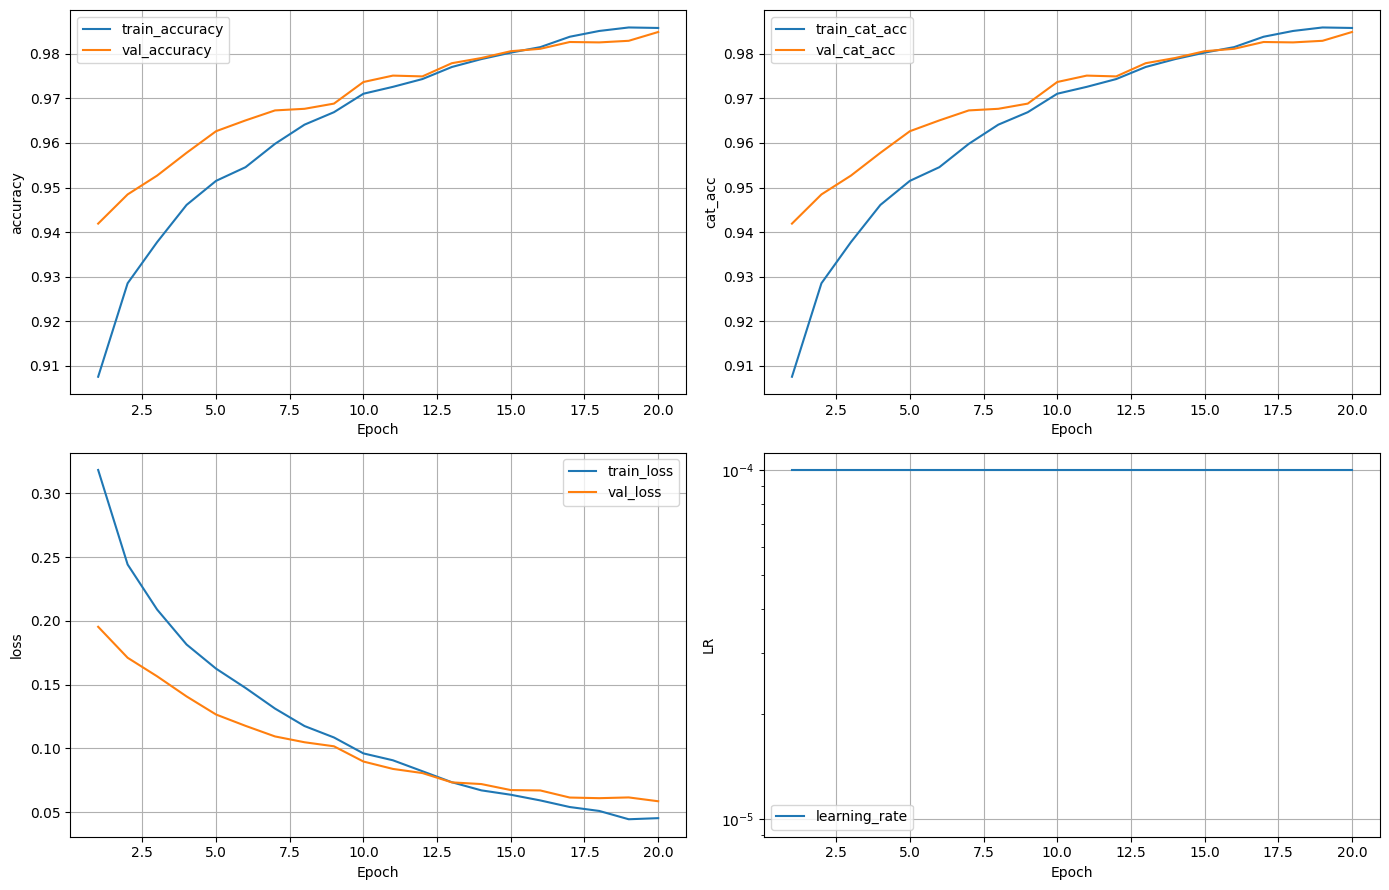

In [29]:
plot_all_history(history)

## Phase 2

In [30]:
# NOW, freeze the bottom layers and train the top layers with smaller batch size && reduced LR

train_ds = make_ds(X_train, y_train,64, True)
val_ds   = make_ds(X_val, y_val, 64)
test_ds  = make_ds(X_test, y_test, 64)

train_ds = train_ds.repeat()
val_ds   = val_ds.repeat()
test_ds  = test_ds.repeat()

# freeze bottom
for layer in model.layers[:-100]:
    layer.trainable = False

# unfreeze top
for layer in model.layers[-100:]:
    layer.trainable = True

# recompile with smaller LR
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [31]:
# train
history_phase2 = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch  = len(X_train) // 64,
    validation_steps = len(X_val) // 64,
    epochs=1,
    callbacks=callbacks,
    verbose=1
)

2026-01-14 07:34:21.991646: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-14 07:34:22.712933: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25802', 12 bytes spill stores, 12 bytes spill loads

2026-01-14 07:34:23.410054: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23889', 1208 bytes spill stores, 1160 bytes spill loads

2026-01-14 07:34:23.521124: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25836'

699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.9671 - loss: 0.1058

2026-01-14 07:43:15.433582: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5451', 13008 bytes spill stores, 13288 bytes spill loads




Epoch 1: val_loss improved from None to 0.05863, saving model to best_model.keras

Epoch 1: finished saving model to best_model.keras
699/699 ━━━━━━━━━━━━━━━━━━━━ 656s 855ms/step - accuracy: 0.9799 - loss: 0.0637 - val_accuracy: 0.9854 - val_loss: 0.0586 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 1.


In [32]:
# train
history_phase2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    steps_per_epoch  = len(X_train) // 64,
    validation_steps = len(X_val) // 64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.9910 - loss: 0.0330
Epoch 1: val_loss improved from 0.05863 to 0.05078, saving model to best_model.keras

Epoch 1: finished saving model to best_model.keras
699/699 ━━━━━━━━━━━━━━━━━━━━ 574s 821ms/step - accuracy: 0.9913 - loss: 0.0318 - val_accuracy: 0.9875 - val_loss: 0.0508 - learning_rate: 1.0000e-05
Epoch 2/20


2026-01-14 07:54:38.317933: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24952', 8 bytes spill stores, 8 bytes spill loads

2026-01-14 07:54:38.730686: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25802', 8 bytes spill stores, 8 bytes spill loads

2026-01-14 07:54:38.859857: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25802', 4 bytes spill stores, 4 bytes spill loads

2026-01-14 07:54:39.070974: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25802', 8 bytes spill stores, 8 bytes spill loads



699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.9932 - loss: 0.0227
Epoch 2: val_loss improved from 0.05078 to 0.05064, saving model to best_model.keras

Epoch 2: finished saving model to best_model.keras
699/699 ━━━━━━━━━━━━━━━━━━━━ 598s 817ms/step - accuracy: 0.9938 - loss: 0.0214 - val_accuracy: 0.9885 - val_loss: 0.0506 - learning_rate: 1.0000e-05
Epoch 3/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.9944 - loss: 0.0184
Epoch 3: val_loss improved from 0.05064 to 0.04988, saving model to best_model.keras

Epoch 3: finished saving model to best_model.keras
699/699 ━━━━━━━━━━━━━━━━━━━━ 572s 819ms/step - accuracy: 0.9947 - loss: 0.0170 - val_accuracy: 0.9899 - val_loss: 0.0499 - learning_rate: 1.0000e-05
Epoch 4/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.9961 - loss: 0.0146
Epoch 4: val_loss improved from 0.04988 to 0.04874, saving model to best_model.keras

Epoch 4: finished saving model to best_model.keras
699/699 ━━━━━━━━━━━━━━━━━━━━ 567s 812m

2026-01-14 08:42:37.300990: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 122882560 bytes after encountering the first element of size 122882560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.9977 - loss: 0.0070
Epoch 7: val_loss did not improve from 0.04874
699/699 ━━━━━━━━━━━━━━━━━━━━ 576s 824ms/step - accuracy: 0.9978 - loss: 0.0070 - val_accuracy: 0.9903 - val_loss: 0.0495 - learning_rate: 1.0000e-05
Epoch 8/20
  6/699 ━━━━━━━━━━━━━━━━━━━━ 7:43 669ms/step - accuracy: 1.0000 - loss: 0.0019

2026-01-14 08:52:13.993606: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 122882560 bytes after encountering the first element of size 122882560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.9976 - loss: 0.0079
Epoch 8: val_loss did not improve from 0.04874
699/699 ━━━━━━━━━━━━━━━━━━━━ 576s 824ms/step - accuracy: 0.9982 - loss: 0.0065 - val_accuracy: 0.9908 - val_loss: 0.0507 - learning_rate: 1.0000e-05
Epoch 9/20
  7/699 ━━━━━━━━━━━━━━━━━━━━ 7:47 675ms/step - accuracy: 1.0000 - loss: 0.0023

2026-01-14 09:01:50.360864: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 122882560 bytes after encountering the first element of size 122882560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.9983 - loss: 0.0059
Epoch 9: val_loss did not improve from 0.04874
699/699 ━━━━━━━━━━━━━━━━━━━━ 576s 824ms/step - accuracy: 0.9983 - loss: 0.0056 - val_accuracy: 0.9910 - val_loss: 0.0511 - learning_rate: 1.0000e-05
Epoch 10/20
  8/699 ━━━━━━━━━━━━━━━━━━━━ 7:43 670ms/step - accuracy: 1.0000 - loss: 0.0044

2026-01-14 09:11:26.481319: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 122882560 bytes after encountering the first element of size 122882560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.9988 - loss: 0.0046
Epoch 10: val_loss did not improve from 0.04874
699/699 ━━━━━━━━━━━━━━━━━━━━ 576s 825ms/step - accuracy: 0.9988 - loss: 0.0044 - val_accuracy: 0.9899 - val_loss: 0.0550 - learning_rate: 1.0000e-05
Epoch 11/20
  9/699 ━━━━━━━━━━━━━━━━━━━━ 7:51 683ms/step - accuracy: 0.9941 - loss: 0.0085

2026-01-14 09:21:03.460137: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 122882560 bytes after encountering the first element of size 122882560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.9987 - loss: 0.0045
Epoch 11: val_loss did not improve from 0.04874

Epoch 11: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
699/699 ━━━━━━━━━━━━━━━━━━━━ 593s 849ms/step - accuracy: 0.9990 - loss: 0.0041 - val_accuracy: 0.9903 - val_loss: 0.0586 - learning_rate: 1.0000e-05
Epoch 12/20
 10/699 ━━━━━━━━━━━━━━━━━━━━ 8:01 699ms/step - accuracy: 0.9990 - loss: 0.0065

2026-01-14 09:30:57.866080: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 122882560 bytes after encountering the first element of size 122882560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.9991 - loss: 0.0036
Epoch 12: val_loss did not improve from 0.04874
699/699 ━━━━━━━━━━━━━━━━━━━━ 590s 844ms/step - accuracy: 0.9993 - loss: 0.0029 - val_accuracy: 0.9906 - val_loss: 0.0550 - learning_rate: 3.0000e-06
Epoch 13/20
 11/699 ━━━━━━━━━━━━━━━━━━━━ 7:57 695ms/step - accuracy: 1.0000 - loss: 6.7478e-04

2026-01-14 09:40:48.360163: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 122882560 bytes after encountering the first element of size 122882560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.9995 - loss: 0.0027
Epoch 13: val_loss did not improve from 0.04874
699/699 ━━━━━━━━━━━━━━━━━━━━ 591s 846ms/step - accuracy: 0.9996 - loss: 0.0023 - val_accuracy: 0.9904 - val_loss: 0.0571 - learning_rate: 3.0000e-06
Epoch 14/20
 12/699 ━━━━━━━━━━━━━━━━━━━━ 7:58 697ms/step - accuracy: 1.0000 - loss: 6.8334e-04

2026-01-14 09:50:40.568691: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 122882560 bytes after encountering the first element of size 122882560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.9994 - loss: 0.0023

2026-01-14 09:58:40.892304: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 122882560 bytes after encountering the first element of size 122882560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 14: val_loss did not improve from 0.04874
699/699 ━━━━━━━━━━━━━━━━━━━━ 594s 849ms/step - accuracy: 0.9994 - loss: 0.0023 - val_accuracy: 0.9905 - val_loss: 0.0561 - learning_rate: 3.0000e-06
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 4.


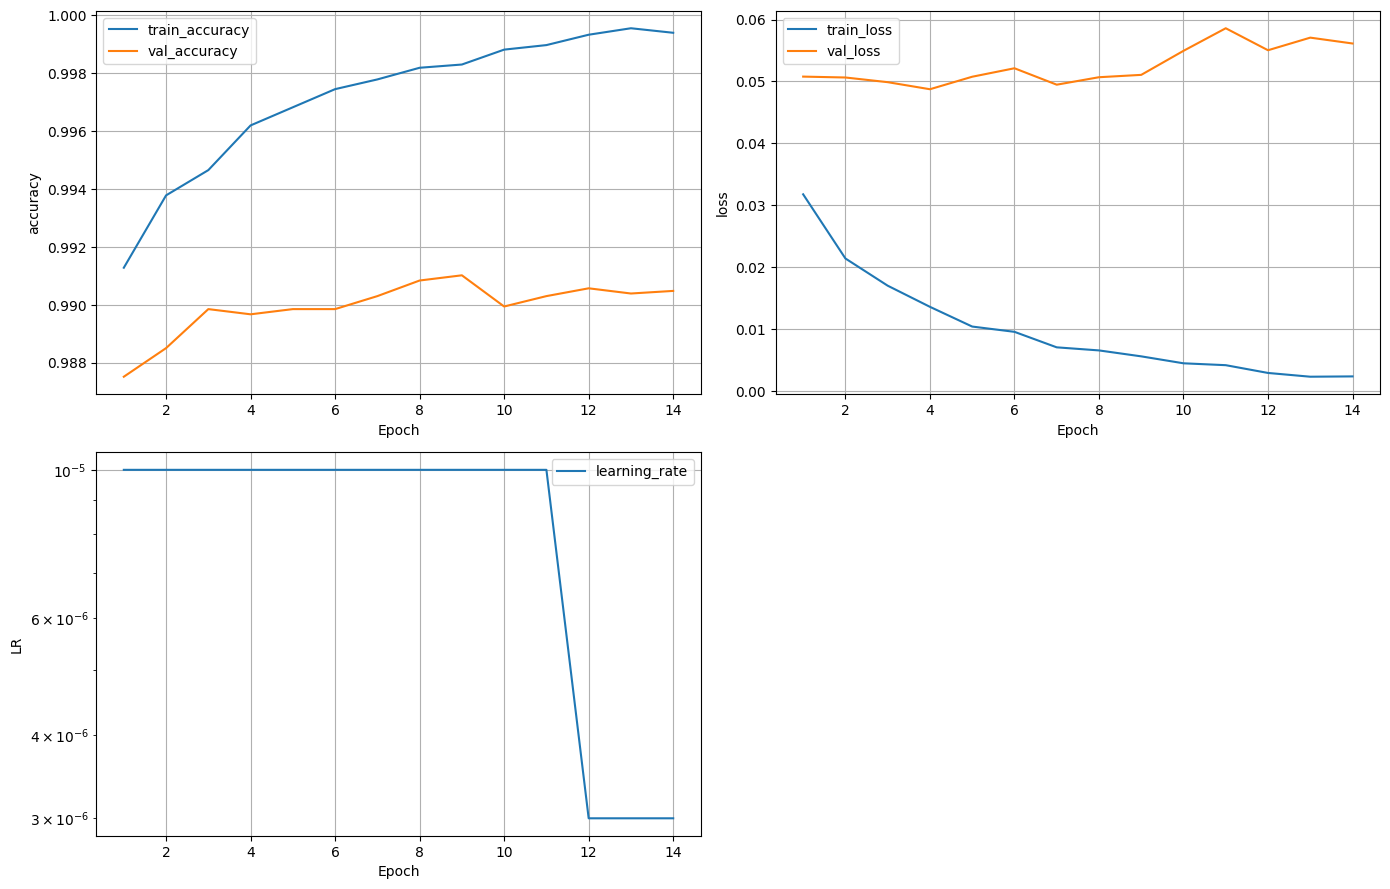

In [33]:
plot_all_history(history_phase2)

In [35]:
print(model.evaluate(test_ds, steps=len(X_test) // 64))

58/58 ━━━━━━━━━━━━━━━━━━━━ 35s 597ms/step - accuracy: 0.9873 - loss: 0.0806
[0.08057866245508194, 0.9873383641242981]


# Phase 3

In [ ]:
# unfreeze all layers of base model except last 300 layers
for layer in model.layers[:-300]:
    layer.trainable = True

# recompile with smaller LR
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
history_phase3 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    steps_per_epoch  = len(X_train) //64,
    validation_steps = len(X_val) // 64,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
model.save("training_complete.keras")

# TESTING

In [ ]:
test_steps = len(X_test) // 64
model.evaluate(test_ds, steps=test_steps)
